In [1]:
# encoding: utf-8

"""
Fixed Evaluation Code for CheXNet
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import densenet121
from sklearn.metrics import roc_auc_score
from read_data import ChestXrayDataSet
from tqdm import tqdm  # For progress tracking

# Constants
CKPT_PATH = 'best_model/5finding_trained_densenet121.pth.tar'  # Path to the trained model
N_CLASSES = 5
#CLASS_NAMES = [
#    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
#    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
#    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
#]
CLASS_NAMES = ["Emphysema", "Cardiomegaly", "Edema", "Effusion", "Atelectasis"]

DATA_DIR = r"C:/Users/zafer/OneDrive/Masaüstü/224NIH/dataset/images-224/images-224"
TEST_IMAGE_LIST = 'labels/test_list_balanced.txt'
BATCH_SIZE = 16


def tensor_transform(crops):
    return torch.stack([transforms.ToTensor()(crop) for crop in crops])


def normalize_transform(crops):
    return torch.stack([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(crop) for crop in crops])


def create_transforms():
    """Create transformations for preprocessing."""
    return transforms.Compose([
        transforms.Resize(256),
        transforms.TenCrop(224),
        transforms.Lambda(tensor_transform),
        transforms.Lambda(normalize_transform)
    ])


class DenseNet121(nn.Module):
    """DenseNet121 model for multi-label classification."""
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = densenet121(pretrained=False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(num_ftrs, out_size)

    def forward(self, x):
        return self.densenet121(x)  # Raw logits output


def load_model():
    """Initialize and load the trained DenseNet121 model."""
    model = DenseNet121(N_CLASSES)
    if os.path.isfile(CKPT_PATH):
        print("=> Loading checkpoint")
        checkpoint = torch.load(CKPT_PATH, map_location="cuda:0")

        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
            # Remove 'module.' prefix if saved with DataParallel
            state_dict = {k.replace('module.', '')
                          .replace("norm.1","norm1")
                          .replace("conv.1","conv1")
                          .replace("norm.2","norm2")
                          .replace("conv.2","conv2")
                          .replace("classifier.0","classifier"): v for k, v in state_dict.items()}
            model.load_state_dict(state_dict)
        else:
            model.load_state_dict(checkpoint)

        print("=> Checkpoint loaded")
    else:
        print("=> No checkpoint found at the specified path")

    return model


def evaluate_model(model, test_loader):
    """Evaluate the model and compute AUROC."""
    model.eval()  # Set the model to evaluation mode
    gt, pred = [], []

    with torch.no_grad():
        for inp, target in tqdm(test_loader, desc="Evaluating", leave=True):
            target = target.cuda()
            bs, n_crops, c, h, w = inp.size()
            inp = inp.view(-1, c, h, w).cuda()

            # Get raw logits and apply sigmoid
            logits = model(inp)
            output_mean = torch.sigmoid(logits.view(bs, n_crops, -1).mean(1))

            gt.append(target.cpu())
            pred.append(output_mean.cpu())

    gt = torch.cat(gt)
    pred = torch.cat(pred)
    return compute_AUCs(gt, pred)


def compute_AUCs(gt, pred):
    """Compute Area Under the Curve (AUC) for all classes."""
    gt_np = gt.numpy()
    pred_np = pred.numpy()
    AUROCs = [roc_auc_score(gt_np[:, i], pred_np[:, i]) for i in range(N_CLASSES)]
    return AUROCs


def main():
    cudnn.benchmark = True  # Enable optimized GPU performance

    # Load model
    model = load_model()
    model = model.cuda()

    # Prepare data
    transform = create_transforms()
    test_dataset = ChestXrayDataSet(data_dir=DATA_DIR, image_list_file=TEST_IMAGE_LIST, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    # Evaluate
    AUROCs = evaluate_model(model, test_loader)
    AUROC_avg = np.mean(AUROCs)

    print(f'The average AUROC is {AUROC_avg:.3f}')
    for i, auroc in enumerate(AUROCs):
        print(f'The AUROC of {CLASS_NAMES[i]} is {auroc:.3f}')


if __name__ == '__main__':
    main()


C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\zafer\AppData\Local\Temp\ipykernel_16480\1103524381.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary 

=> Loading checkpoint
=> Checkpoint loaded


Evaluating: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]

The average AUROC is 0.557
The AUROC of Emphysema is 0.451
The AUROC of Cardiomegaly is 0.507
The AUROC of Edema is 0.656
The AUROC of Effusion is 0.623
The AUROC of Atelectasis is 0.547


**Step 1: Define a Function for Confusion Matrices**

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_confusion_matrices(gt, pred, threshold=0.5):
    """Compute confusion matrices for each class."""
    gt_np = gt.numpy()
    pred_np = (pred.numpy() > threshold).astype(int)  # Apply threshold to predictions

    confusion_matrices = []
    for i in range(N_CLASSES):
        cm = confusion_matrix(gt_np[:, i], pred_np[:, i])
        confusion_matrices.append(cm)

    return confusion_matrices


**Step 2: Visualize Confusion Matrices**

In [3]:
def plot_confusion_matrix(cm, class_name):
    """Plot confusion matrix."""
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [13]:
# Load model
model = load_model()
model = model.cuda()

# Prepare data
transform = create_transforms()
test_dataset = ChestXrayDataSet(data_dir=DATA_DIR, image_list_file=TEST_IMAGE_LIST, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Evaluate to get gt and pred
gt, pred = [], []
model.eval()
with torch.no_grad():
    for inp, target in tqdm(test_loader, desc="Evaluating", leave=True):
        target = target.cuda()
        bs, n_crops, c, h, w = inp.size()
        inp = inp.view(-1, c, h, w).cuda()
        logits = model(inp)
        output_mean = torch.sigmoid(logits.view(bs, n_crops, -1).mean(1))
        gt.append(target.cpu())
        pred.append(output_mean.cpu())
gt = torch.cat(gt)
pred = torch.cat(pred)

# Compute confusion matrices
# Compute confusion matrices
confusion_matrices = compute_confusion_matrices(gt, pred)

# Print confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f'Confusion Matrix for {CLASS_NAMES[i]}:\n{cm}\n')



C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\zafer\AppData\Local\Temp\ipykernel_16480\1103524381.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary 

=> Loading checkpoint
=> Checkpoint loaded


Evaluating: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]

Confusion Matrix for Emphysema:
[[956   0]
 [ 44   0]]

Confusion Matrix for Cardiomegaly:
[[942   0]
 [ 58   0]]

Confusion Matrix for Edema:
[[968   0]
 [ 32   0]]

Confusion Matrix for Effusion:
[[737   2]
 [261   0]]

Confusion Matrix for Atelectasis:
[[761   0]
 [239   0]]



**1. Precision, Recall, and F1 Score**

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_precision_recall_f1(gt, pred, threshold=0.5):
    """
    Compute precision, recall, and F1 score for each class.
    
    Parameters:
    - gt: Tensor of ground truth labels (shape: [num_samples, num_classes]).
    - pred: Tensor of predicted probabilities (shape: [num_samples, num_classes]).
    - threshold: Threshold for converting probabilities to binary predictions.
    
    Returns:
    - precisions: List of precision scores for each class.
    - recalls: List of recall scores for each class.
    - f1_scores: List of F1 scores for each class.
    """
    # Convert tensors to numpy arrays
    gt_np = gt.cpu().numpy()
    pred_np = (pred.cpu().numpy() > threshold).astype(int)  # Apply threshold to predictions

    # Initialize lists to store metrics
    precisions = []
    recalls = []
    f1_scores = []

    # Loop over each class and calculate metrics
    num_classes = gt_np.shape[1]
    for i in range(num_classes):
        precisions.append(precision_score(gt_np[:, i], pred_np[:, i], zero_division=0))
        recalls.append(recall_score(gt_np[:, i], pred_np[:, i], zero_division=0))
        f1_scores.append(f1_score(gt_np[:, i], pred_np[:, i], zero_division=0))

    return precisions, recalls, f1_scores


**2. Class-Wise Analysis**

In [22]:
# Assuming gt and pred are tensors of shape [num_samples, num_classes]
precisions, recalls, f1_scores = compute_precision_recall_f1(gt, pred, threshold=0.3)

# Print the metrics
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name}: Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")


Emphysema: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Cardiomegaly: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Edema: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Effusion: Precision=0.3391, Recall=0.6054, F1-Score=0.4347
Atelectasis: Precision=0.2500, Recall=0.4854, F1-Score=0.3300


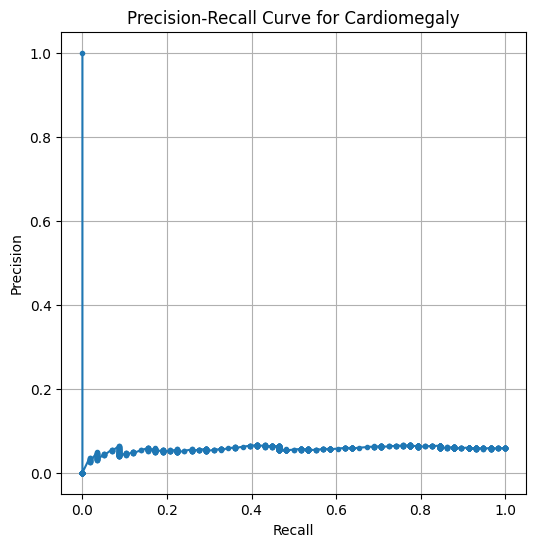

In [23]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_pr_curve(gt, pred, class_name):
    """Plot the Precision-Recall curve for a specific class."""
    precision, recall, _ = precision_recall_curve(gt.numpy(), pred.numpy())
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, marker='.')
    plt.title(f'Precision-Recall Curve for {class_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

# Plot PR curve for a specific class, e.g., Cardiomegaly (index 1)
plot_pr_curve(gt[:, 1], pred[:, 1], "Cardiomegaly")


***4. Threshold Optimization***

In [24]:
from sklearn.metrics import accuracy_score

def optimize_thresholds(gt, pred):
    """Find the optimal threshold for each class."""
    gt_np = gt.numpy()
    pred_np = pred.numpy()
    optimal_thresholds = []

    for i in range(N_CLASSES):
        best_threshold = 0.5
        best_f1 = 0
        for t in np.arange(0.0, 1.01, 0.01):
            pred_class = (pred_np[:, i] > t).astype(int)
            f1 = f1_score(gt_np[:, i], pred_class, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
        optimal_thresholds.append(best_threshold)

    return optimal_thresholds

# Find and print optimal thresholds
optimal_thresholds = optimize_thresholds(gt, pred)
print("\nOptimal Thresholds:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name}: {optimal_thresholds[i]:.2f}")



Optimal Thresholds:
Emphysema: 0.00
Cardiomegaly: 0.04
Edema: 0.10
Effusion: 0.26
Atelectasis: 0.24


In [9]:
def analyze_errors(gt, pred, threshold=0.5):
    """Analyze false positives and false negatives for each class."""
    gt_np = gt.numpy()
    pred_np = (pred.numpy() > threshold).astype(int)

    for i, class_name in enumerate(CLASS_NAMES):
        false_positives = np.sum((pred_np[:, i] == 1) & (gt_np[:, i] == 0))
        false_negatives = np.sum((pred_np[:, i] == 0) & (gt_np[:, i] == 1))
        print(f"{class_name}: False Positives = {false_positives}, False Negatives = {false_negatives}")


In [10]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(gt, pred, class_name):
    """Plot the calibration curve for a specific class."""
    prob_true, prob_pred = calibration_curve(gt.numpy(), pred.numpy(), n_bins=10)
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='.')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal reference line
    plt.title(f'Calibration Curve for {class_name}')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.grid(True)
    plt.show()

# Plot calibration curve for a specific class, e.g., Pneumonia (index 6)
plot_calibration_curve(gt[:, 6], pred[:, 6], "Pneumonia")


IndexError: index 6 is out of bounds for dimension 1 with size 5

**Modify the Model for Grad-CAM**

In [13]:
class DenseNet121(nn.Module):
    """DenseNet121 model for multi-label classification."""
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = densenet121(pretrained=False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(num_ftrs, out_size)
        self.features = self.densenet121.features  # Access the convolutional features
        self.classifier = self.densenet121.classifier

    def forward(self, x):
        features = self.features(x)
        out = nn.ReLU(inplace=True)(features)  # Activation
        out = nn.AdaptiveAvgPool2d((1, 1))(out).view(features.size(0), -1)  # Global Pooling
        out = self.classifier(out)
        return out, features  # Return features for Grad-CAM


In [14]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook the gradients and activations
        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        """Generate Grad-CAM heatmap for the target class index."""
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # Global average of gradients
        heatmap = torch.sum(weights * self.activations, dim=1).squeeze(0)
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)  # Normalize to [0, 1]
        return heatmap.cpu().detach().numpy()


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """Overlay the heatmap on the original image."""
    heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), colormap)
    overlay = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)
    return overlay

def preprocess_image(image_path):
    """Preprocess an image for the model."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image, input_tensor


In [17]:
def gradcam_example_random(model, dataset, class_idx):
    # Pick a random image with the specified class
    raw_image, target = pick_random_image_with_class(dataset, class_idx)
    print(f"Randomly selected image has target labels: {target}")

    # Preprocess the image for the model
    transform = create_transforms()  # Assuming you have the same transform function
    input_tensor = transform(raw_image.unsqueeze(0))  # Add batch dimension

    # Run the model and compute gradients
    model.eval()
    input_tensor = input_tensor.cuda()
    model = model.cuda()
    output, features = model(input_tensor)
    loss = output[0, class_idx]
    model.zero_grad()
    loss.backward()

    # Generate Grad-CAM heatmap
    grad_cam = GradCAM(model, model.features[-1])
    heatmap = grad_cam.generate_heatmap(class_idx)

    # Overlay heatmap on the image
    heatmap_resized = cv2.resize(heatmap, (raw_image.size(1), raw_image.size(2)))
    heatmap_overlay = overlay_heatmap(np.array(raw_image.permute(1, 2, 0).cpu() * 255, dtype=np.uint8), heatmap_resized)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image.permute(1, 2, 0).cpu())
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()


In [18]:
import random

def pick_random_image_with_class(dataset, class_idx):
    """Pick a random image from the dataset with the specified class."""
    indices = []
    for i in range(len(dataset)):
        _, target = dataset[i]
        if target[class_idx] == 1:  # Check if the class is positive
            indices.append(i)

    if len(indices) == 0:
        raise ValueError(f"No images found with class index {class_idx} as positive.")

    selected_idx = random.choice(indices)
    image, target = dataset[selected_idx]
    return image, target


In [19]:
# Assuming you have defined the `ChestXrayDataSet` class
transform = create_transforms()
test_dataset = ChestXrayDataSet(data_dir=DATA_DIR, image_list_file=TEST_IMAGE_LIST, transform=transform)

# Use the function with a random Cardiomegaly image
class_idx = 1  # Cardiomegaly index
gradcam_example_random(model, test_dataset, class_idx)


Randomly selected image has target labels: tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [3, 224, 224] and output size of [256, 256]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.